# download data

In [1]:
#It is preferable to run this notebook in Google Colab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import json
import zipfile

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
downloaded_ = drive.CreateFile({'id':'1MY_7nRfvLRAiRLtCmzRhienCNkmmwA-f'}) 
downloaded_.GetContentFile('comment-train.csv.zip')
zip_ref = zipfile.ZipFile('comment-train.csv.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
downloaded_ = drive.CreateFile({'id': '19pkTBN55aqyOiM1zVqp290bE3Lrqs5z5'}) 
downloaded_.GetContentFile('unintended-train.csv.zip')
zip_ref = zipfile.ZipFile('unintended-train.csv.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
downloaded_ = drive.CreateFile({'id': '1x3PEmKTz8pCBDmyuuZaPNN6s-E_c68ar'}) 
downloaded_.GetContentFile('test.csv.zip')
zip_ref = zipfile.ZipFile('test.csv.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
downloaded_ = drive.CreateFile({'id': '1ign9HHQpSw_IHzrhcZ833GYSKZ2jljN6'}) 
downloaded_.GetContentFile('validation.csv.zip')
zip_ref = zipfile.ZipFile('validation.csv.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
!head jigsaw-toxic-comment-train.csv

id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0000997932d777bf,"Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
0001b41b1c6bb37e,"""
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents""""  -I think the references may need tidying so

In [ ]:
!ls

adc.json			  test.csv
comment-train.csv.zip		  test.csv.zip
fig1.png			  unintended-train.csv.zip
jigsaw-toxic-comment-train.csv	  validation.csv
jigsaw-unintended-bias-train.csv  validation.csv.zip
sample_data


# Install and import dependencies

In [6]:
!pip install transformers

     |████████████████████████████████| 675kB 8.7MB/s 
     |████████████████████████████████| 3.8MB 22.8MB/s 
     |████████████████████████████████| 1.1MB 60.0MB/s 
     |████████████████████████████████| 890kB 59.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=506ef53a1d7732d828fd81e0ae26529cb34eae21fa6fdf3f59a3a8df0ffbf961
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [7]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import torch
import numpy as np
import os 
import re
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


# EDA

In [8]:
wiki_toxic_comment_train = pd.read_csv("jigsaw-toxic-comment-train.csv")
wiki_toxic_comment_test = pd.read_csv("test.csv", index_col=0)
wiki_toxic_comment_valid = pd.read_csv("validation.csv", index_col=0)

# Data Analisys

**Задание:**

Анализ всех дополнительных колонок тональности (как проявляется тот или иной тип токсичности, как в данных это представлено, какие есть пограничные случаи) - 2.5 балла

## train

Для начала посмотрим на тест

In [ ]:
wiki_toxic_comment_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
len(wiki_toxic_comment_train)

223549

В трейне представлены 223549 текстов только на английском языке, при этом токсичные тексты также имеют разбиение по типам токсичности 

Посмотрим, на токсичность и проверим у всех ди токсичных текстов есть тип:

In [34]:
print("Количество токсичных текстов (по классу toxic):")
non_toxic_all = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] != 1)]
toxic_all = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 1)]
print(len(toxic_all))
print("Количество токсичных текстов, не имеющих тип токсичности:")
toxic_no_type = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 1) &
                                        (wiki_toxic_comment_train["identity_hate"]!=1) & 
                                        (wiki_toxic_comment_train["severe_toxic"]!=1) &
                                        (wiki_toxic_comment_train["insult"]!=1) & 
                                        (wiki_toxic_comment_train["threat"]!=1) & 
                                        (wiki_toxic_comment_train["obscene"]!=1)]
print(len(toxic_no_type))

Количество токсичных текстов (по классу toxic):
21384
Количество токсичных текстов, не имеющих тип токсичности:
7376


Хм, тип есть не у всех текстов, может быть есть тексты, у которых есть тип токсичности, но нет метки toxic (ну мало ли у них совсем странная разметка)

In [33]:
wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 0) &
                                        (wiki_toxic_comment_train["identity_hate"]==1) & 
                                        (wiki_toxic_comment_train["severe_toxic"]==1) &
                                        (wiki_toxic_comment_train["insult"]==1) & 
                                        (wiki_toxic_comment_train["threat"]==1) & 
                                        (wiki_toxic_comment_train["obscene"]==1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [35]:
Таких текстов, к счастью нет

Посмотрим сначала более общим взглядом 

SyntaxError: ignored

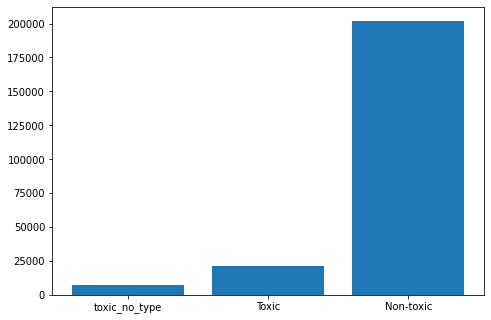

In [37]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["toxic_no_type", 'Toxic', 'Non-toxic' ]
d = [len(toxic_no_type), len(toxic_all), len(non_toxic_all)]
ax.bar(labels,d)
plt.show()

In [41]:
print("Percent of toxic_no_type texts in corpus = ", len(toxic_no_type)/len(wiki_toxic_comment_train)*100)
print("Percent of toxic_all texts in corpus = ", len(toxic_all)/len(wiki_toxic_comment_train)*100)

Percent of toxic_no_type texts in corpus =  3.2995003332602697
Percent of toxic_all texts in corpus =  9.565688059441108


Мы видим, что классы токсичный/нетоксичный соотносятся как 1 к 10 (если мы учитываем токсичные тексты всех типов), если же мы захотим использовать только тексты без дополнительной разметки, то у размер целевого класса едва будет превышать 3 процента

Посмотрим как обстоят дела в самих типах токсичности:

In [32]:
print("Количество токсичных текстов по типам:")
print("identity_hate:")
toxic_identity_hate = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 1) & (wiki_toxic_comment_train["identity_hate"]==1)]
non_toxic_identity_hate = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 0) & (wiki_toxic_comment_train["identity_hate"]==1)]
print(len(toxic_identity_hate))
print("severe_toxic:")
toxic_severe_toxic = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 1) & (wiki_toxic_comment_train["severe_toxic"]==1)]
non_toxic_severe_toxic = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 0) & (wiki_toxic_comment_train["severe_toxic"]==1)]
print(len(toxic_severe_toxic))
print("insult:")
toxic_insult = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 1) & (wiki_toxic_comment_train["insult"]==1)]
non_toxic_insult = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 0) & (wiki_toxic_comment_train["insult"]==1)]
print(len(toxic_insult))
print("threat:")
toxic_threat = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 1) & (wiki_toxic_comment_train["threat"]==1)]
non_toxic_threat = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 0) & (wiki_toxic_comment_train["threat"]==1)]
print(len(toxic_threat))
print("obscene:")
toxic_obscene = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 1) & (wiki_toxic_comment_train["obscene"]==1)]
non_toxic_obscene = wiki_toxic_comment_train[(wiki_toxic_comment_train["toxic"] == 0) & (wiki_toxic_comment_train["obscene"]==1)]
print(len(toxic_obscene))
                                  

Количество токсичных текстов по типам:
identity_hate:
1995
severe_toxic:
1962
insult:
10686
threat:
654
obscene:
11552


In [42]:
import matplotlib.pyplot as plt

def plot_toxic_ratio(data, title, labels):
  toxic_num = [data[label].value_counts()[1] for label in labels]
  non_toxic_num = [data[label].value_counts()[0] for label in labels]

  width = 0.35 

  fig, ax = plt.subplots()

  ax.bar(labels, non_toxic_num, width, label='non_toxic_num')
  ax.bar(labels, toxic_num , width,  bottom=non_toxic_num ,
        label='toxic_by_type_num ')

  ax.set_ylabel('Number of coments')
  ax.set_title(title)
  ax.legend()

  plt.show()


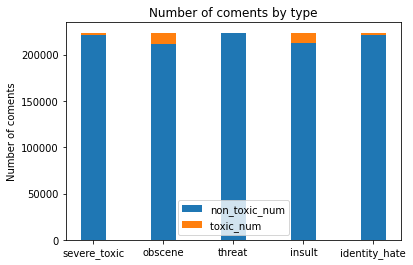

In [ ]:
labels = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
title = 'Number of coments by type'
plot_toxic_ratio(wiki_toxic_comment_train, title, labels)

Здесь мы видим очень сильный дисбаланс по типам токсичности.

Посмотрим на процент токсичных текстов каждого типа в выборке

In [ ]:
toxic_ratio = [toxic_num[i]/(toxic_num[i]+non_toxic_num[i])*100 for i in range(len(toxic_num))]
[print("Ratio of toxic comments in ", labels[i], " = ", toxic_ratio[i], "\n") for i in range(len(toxic_ratio))]

Ratio of toxic comments in  severe_toxic  =  0.8776599313796976 

Ratio of toxic comments in  obscene  =  5.430576741564489 

Ratio of toxic comments in  threat  =  0.30820983319093354 

Ratio of toxic comments in  insult  =  5.056609512903211 

Ratio of toxic comments in  identity_hate  =  0.9469959606171354 



[None, None, None, None, None]

Можно заметить что процент отдельных типов даже выше, чем процент токсичных текстов без метки типа

Посмотрим как распледелены тексты по длине в разных классах

In [50]:
wiki_toxic_comment_train["len_text"] = wiki_toxic_comment_train["comment_text"].apply(lambda x: len(str(x)))

In [ ]:
wiki_toxic_comment_train["len_text"].describe()

count    223549.000000
mean        391.012709
std         592.862955
min           1.000000
25%          93.000000
50%         203.000000
75%         431.000000
max        5000.000000
Name: len_text, dtype: float64

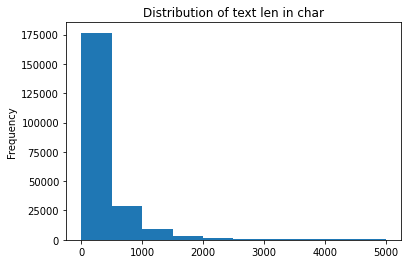

In [ ]:
wiki_toxic_comment_train["len_text"].plot.hist(title="Distribution of text len in char")
plt.show()

уже видим, что по длине у нас много выбросов, но посмотрим относительно токсичных/нетоксичных текстов

In [ ]:

def box_toxic_len(toxic_len, non_toxic_len):
  # Create a figure instance
  fig = plt.figure(1, figsize=(9, 6))

  # Create an axes instance
  ax = fig.add_subplot(111)

  # Create the boxplot
  bp = ax.boxplot([toxic_len, non_toxic_len])

  # Save the figure
  fig.savefig('fig1.png', bbox_inches='tight')

  ## add patch_artist=True option to ax.boxplot() 
  ## to get fill color
  bp = ax.boxplot([toxic_len, non_toxic_len], patch_artist=True)

  ## change outline color, fill color and linewidth of the boxes
  for box in bp['boxes']:
      # change outline color
      box.set( color='#7570b3', linewidth=2)
      # change fill color
      box.set( facecolor = '#1b9e77' )

  ## change color and linewidth of the whiskers
  for whisker in bp['whiskers']:
      whisker.set(color='#7570b3', linewidth=2)

  ## change color and linewidth of the caps
  for cap in bp['caps']:
      cap.set(color='#7570b3', linewidth=2)

  ## change color and linewidth of the medians
  for median in bp['medians']:
      median.set(color='#b2df8a', linewidth=2)

  ## change the style of fliers and their fill
  for flier in bp['fliers']:
      flier.set(marker='o', color='#e7298a', alpha=0.5)

  ## Custom x-axis labels
  ax.set_xticklabels(["toxic_len", "non_toxic_len"])

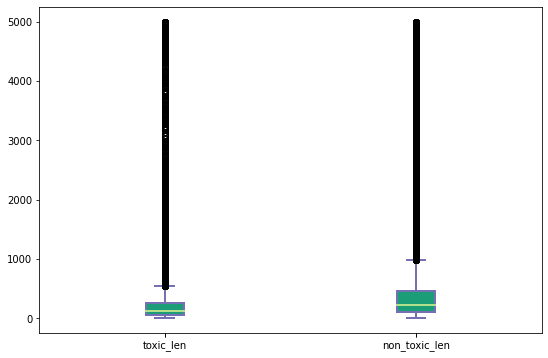

In [ ]:
toxic_len = wiki_toxic_comment_train[wiki_toxic_comment_train.toxic == 1]["len_text"]
non_toxic_len = wiki_toxic_comment_train[wiki_toxic_comment_train.toxic == 0]["len_text"]
box_toxic_len(toxic_len, non_toxic_len)

Выбросов действительно много, в неточксичных текстах мы видим, что выбросы начинаются с большей длины а матожидание длины токсичных текстов значительно меньше чем у нетоксичных, возможно, это поможет при обучении

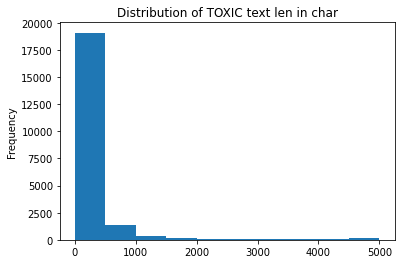

In [ ]:
wiki_toxic_comment_train[wiki_toxic_comment_train.toxic == 1]["len_text"].plot.hist(title="Distribution of TOXIC text len in char")
plt.show()

Посмотрим, что происходит в типах токсичности

In [ ]:
# from matplotlib.patches import Polygon
def box_plot(data, top, labels):





  fig, ax1 = plt.subplots(figsize=(10, 6))
  fig.canvas.set_window_title('A Boxplot Example')
  fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

  bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
  plt.setp(bp['boxes'], color='black')
  plt.setp(bp['whiskers'], color='black')
  plt.setp(bp['fliers'], color='red', marker='+')

  # Add a horizontal grid to the plot, but make it very light in color
  # so we can use it for reading data values but not be distracting
  ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                alpha=0.5)

  # Hide these grid behind plot objects
  ax1.set_axisbelow(True)
  ax1.set_title('Length of Toxic and Non-toxic comments by group')
  ax1.set_xlabel('Type of toxic comments')
  ax1.set_ylabel('Length on char')

  # Now fill the boxes with desired colors
  box_colors = ['darkkhaki', 'royalblue']
  num_boxes = len(data)
  medians = np.empty(num_boxes)
  for i in range(num_boxes):
      box = bp['boxes'][i]
      boxX = []
      boxY = []
      for j in range(5):
          boxX.append(box.get_xdata()[j])
          boxY.append(box.get_ydata()[j])
      box_coords = np.column_stack([boxX, boxY])
      # Alternate between Dark Khaki and Royal Blue
      ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))
      # Now draw the median lines back over what we just filled in
      med = bp['medians'][i]
      medianX = []
      medianY = []
      for j in range(2):
          medianX.append(med.get_xdata()[j])
          medianY.append(med.get_ydata()[j])
          ax1.plot(medianX, medianY, 'k')
      medians[i] = medianY[0]
      # Finally, overplot the sample averages, with horizontal alignment
      # in the center of each box
      ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
              color='w', marker='*', markeredgecolor='k')

  # Set the axes ranges and axes labels
  ax1.set_xlim(0.5, num_boxes + 0.5)
  top = top
  bottom = -5
  ax1.set_ylim(bottom, top)
  ax1.set_xticklabels(np.repeat(labels, 2),
                      rotation=45, fontsize=8)

  # Due to the Y-axis scale being different across samples, it can be
  # hard to compare differences in medians across the samples. Add upper
  # X-axis tick labels with the sample medians to aid in comparison
  # (just use two decimal places of precision)
  pos = np.arange(num_boxes) + 1
  upper_labels = [str(np.round(s, 2)) for s in medians]
  weights = ['bold', 'semibold']
  for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
      k = tick % 2
      ax1.text(pos[tick], .95, upper_labels[tick],
              transform=ax1.get_xaxis_transform(),
              horizontalalignment='center', size='x-small',
              weight=weights[k], color=box_colors[k])

  # Finally, add a basic legend
  fig.text(0.80, 0.08, f' Non-toxic',
          backgroundcolor=box_colors[0], color='black', weight='roman',
          size='x-small')
  fig.text(0.80, 0.045, ' Toxic',
          backgroundcolor=box_colors[1],
          color='white', weight='roman', size='x-small')
  fig.text(0.80, 0.015, '*', color='white', backgroundcolor='silver',
          weight='roman', size='medium')
  fig.text(0.815, 0.013, ' Average Value', color='black', weight='roman',
          size='x-small')

  plt.show()

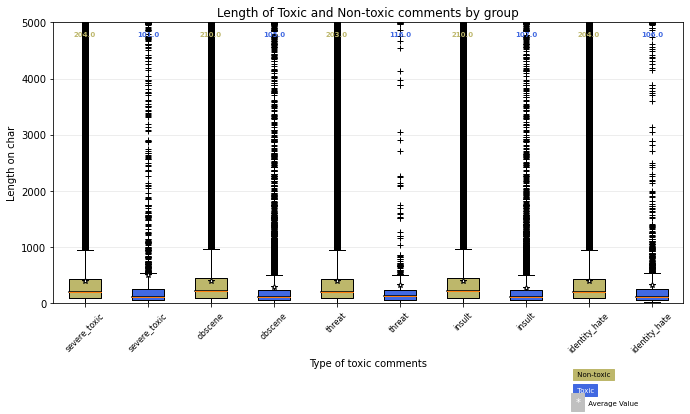

In [ ]:
x = 5000
labels = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data_X = wiki_toxic_comment_train
data = [data_X[data_X.severe_toxic == 0]["len_text"],
        data_X[data_X.severe_toxic == 1]["len_text"],
        data_X[data_X.obscene == 0]["len_text"],
        data_X[data_X.obscene == 1]["len_text"],
        data_X[data_X.threat == 0]["len_text"],
        data_X[data_X.threat == 1]["len_text"],
        data_X[data_X.insult == 0]["len_text"],
        data_X[data_X.insult == 1]["len_text"],
        data_X[data_X.identity_hate == 0]["len_text"],
        data_X[data_X.identity_hate == 1]["len_text"]
]

box_plot(data, x, labels)

Здесь нас на самом деле не очень интересует распределение в нетоксичных комментариях, потому что это +- одни и те же тексты (все нетоксичные + небольшая часть других типов токсичности), но для наглядности пусть будут

Нам интересно посмотреть на распределение токсичных типов, но из-за большого хвоста выбросов рассмотреть что-то сложно, уберем все, что больше 1000

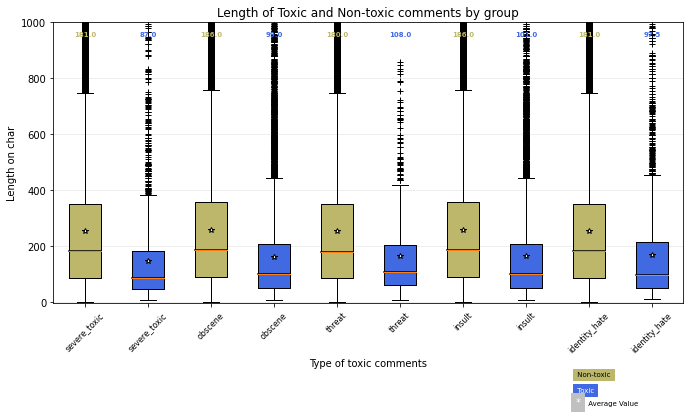

In [ ]:
x = 1000
labels = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data_X = wiki_toxic_comment_train[wiki_toxic_comment_train["len_text"]<=x]
data = [data_X[data_X.severe_toxic == 0]["len_text"],
        data_X[data_X.severe_toxic == 1]["len_text"],
        data_X[data_X.obscene == 0]["len_text"],
        data_X[data_X.obscene == 1]["len_text"],
        data_X[data_X.threat == 0]["len_text"],
        data_X[data_X.threat == 1]["len_text"],
        data_X[data_X.insult == 0]["len_text"],
        data_X[data_X.insult == 1]["len_text"],
        data_X[data_X.identity_hate == 0]["len_text"],
        data_X[data_X.identity_hate == 1]["len_text"]
]
box_plot(data, x, labels)

уже лучше, но мы не угадали и граница выбросов не 1000 а чуть меньше 800, отрежем еще чуть-чуть

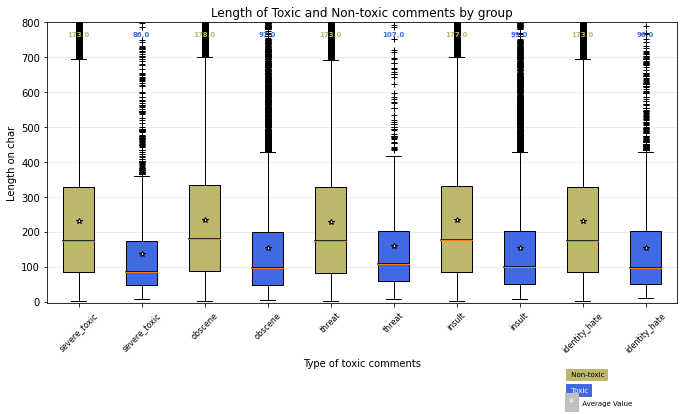

In [ ]:
x = 800
labels = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data_X = wiki_toxic_comment_train[wiki_toxic_comment_train["len_text"]<=x]
data = [data_X[data_X.severe_toxic == 0]["len_text"],
        data_X[data_X.severe_toxic == 1]["len_text"],
        data_X[data_X.obscene == 0]["len_text"],
        data_X[data_X.obscene == 1]["len_text"],
        data_X[data_X.threat == 0]["len_text"],
        data_X[data_X.threat == 1]["len_text"],
        data_X[data_X.insult == 0]["len_text"],
        data_X[data_X.insult == 1]["len_text"],
        data_X[data_X.identity_hate == 0]["len_text"],
        data_X[data_X.identity_hate == 1]["len_text"]
]
box_plot(data, x,labels)

Теперь видно, что распределние по всем группам, кроме первой примерно одинаковое (матожидание, дисперсия и квантили похожи), в первом все показатели меньше, чем у остальных

А также теперь намного надляднее сильная разница в матожидании, дисперсии (суть среднем размере) длин токсичных и нетоксичных текстов - почти в два раза!

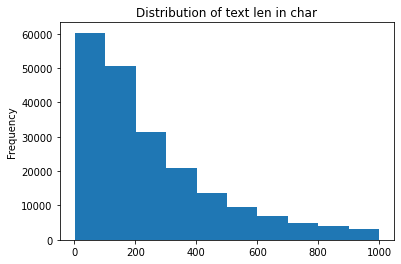

In [ ]:
wiki_toxic_comment_train[wiki_toxic_comment_train["len_text"]<=1000]["len_text"].plot.hist(title="Distribution of text len in char")
plt.show()

## validation

На валидации у нас уже 3 языка, а текстов всего 8000, также нет разбиения по типам токсичности. Посмотрим то же, что для трейна, только с учетом языков

In [ ]:
wiki_toxic_comment_valid

,comment_text,lang,toxic
id,,,
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0
...,...,...,...
7995,Il fatto è che la pagina dei personaggi minor...,it,0
7996,El imbesil ete dela luna no se entera ni ostia...,es,1
7997,olum sız manyakmısınz siz adam sıze sanal yıld...,tr,1


In [ ]:
wiki_toxic_comment_valid[wiki_toxic_comment_valid.toxic == 0]["lang"].value_counts()

tr    2680
es    2078
it    2012
Name: lang, dtype: int64

In [43]:
import matplotlib.pyplot as plt

def plot_toxic_ratio(data, title, labels):
  toxic_value = data[data.toxic == 1]["lang"].value_counts()
  non_toxic_value =  data[data.toxic == 0]["lang"].value_counts()
  toxic_num = [toxic_value[i] for i in range(len(labels))]
  non_toxic_num = [non_toxic_value[i] for i in range(len(labels))]

  width = 0.35 

  fig, ax = plt.subplots()

  ax.bar(labels, non_toxic_num, width, label='non_toxic_num')
  ax.bar(labels, toxic_num , width,  bottom=non_toxic_num ,
        label='toxic_num ')

  ax.set_ylabel('Number of coments')
  ax.set_title(title)
  ax.legend()

  plt.show()

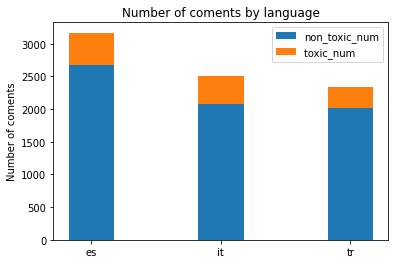

In [44]:
labels = ['es', 'it', 'tr']
title = 'Number of coments by language'
plot_toxic_ratio(wiki_toxic_comment_valid, title, labels)

In [48]:
toxic_value = wiki_toxic_comment_valid[wiki_toxic_comment_valid.toxic == 1]

print("Percent of toxic texts in dataset =" ,len(toxic_value)/len(wiki_toxic_comment_valid)*100)

Percent of toxic texts in dataset = 15.375


Мы видим, что распределние текстов по языкам примерно равное, однако в токсичности опять сильный дисбаланс, при чем соотношение на валидации отличается от соотношения на тексте (здесь процент токсичных текстов выше на 5 процентов)

In [49]:
wiki_toxic_comment_valid["len_text"] = wiki_toxic_comment_valid["comment_text"].apply(lambda x: len(str(x)))

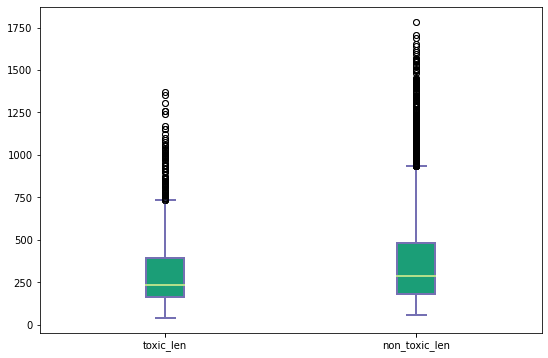

In [ ]:
toxic_len = wiki_toxic_comment_valid[wiki_toxic_comment_valid.toxic == 1]["len_text"]
non_toxic_len = wiki_toxic_comment_valid[wiki_toxic_comment_valid.toxic == 0]["len_text"]
box_toxic_len(toxic_len, non_toxic_len)

Максимальная длина текста здесь 1785 против 5000 на трейне, а выбраcов уже поменьше, хотя мы видим, что они отсекаются примерно на той же границе, что и в трейне, возможно, стоит использовать при обучении только тексты длины меньше какого-то порога, отсекающего достаточное количество выбросов (около 1000 символов, но посмотрим на положение дел в каждом языке, чтобы случайно не отрезать лишнее)

Стоит отметить, что и на валидации у нас тексты в среднем длиннее (мы видим, что матожидание длины токсичных текстов здесь около 250, в то время как на трейне он около 100), но в целом это неудивитлеьно и связано с тем, что у нас все же разные языки, плюс здесь есть турецкий, он агглютинативный и есть догадка, что это он вносит большую долю в увеличение среднего размера текстов

In [ ]:
wiki_toxic_comment_valid["len_text"].describe()

count    8000.000000
mean      368.988000
std       271.620356
min        39.000000
25%       175.000000
50%       278.000000
75%       469.000000
max      1785.000000
Name: len_text, dtype: float64

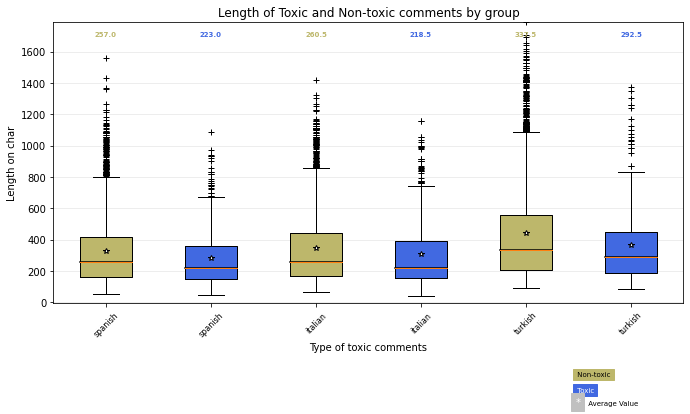

In [ ]:
x = wiki_toxic_comment_valid["len_text"].max()
labels = ['spanish', 'italian', 'turkish']
# data_X = wiki_toxic_comment_train[wiki_toxic_comment_train["len_text"]<=x]
data_X = wiki_toxic_comment_valid
data_X_toxic = data_X[data_X.toxic == 1]
data_X_non_toxic = data_X[data_X.toxic == 0]
data = [data_X_non_toxic[data_X_non_toxic.lang == "es"]["len_text"],
        data_X_toxic[data_X_toxic.lang == "es"]["len_text"],
        data_X_non_toxic[data_X_non_toxic.lang == "it"]["len_text"],
        data_X_toxic[data_X_toxic.lang == "it"]["len_text"],
        data_X_non_toxic[data_X_non_toxic.lang == "tr"]["len_text"],
        data_X_toxic[data_X_toxic.lang == "tr"]["len_text"]
]
box_plot(data, x, labels)


Здесь нас уже интересуют и токсичные и нетоксичные тексты (теперь это разные тексты)

1) Длина испанских и итальянских текстов в среднем и в максимальных значениях меньше, чем у турецких текстов, что неудивительно, учитывая, что турецкий аглютинативный (а значит там за счет богатой морфологии увеличивается длина слов, а длину текстов мы измеряем в символах), а испанский и итальянский - синтетические (там морфология также развита, но слабее, в связи с чем и длина слов меньше)

2) Визуально процентов выбросов для всех языков примерно одинаков, это дает надежду, что все же несмотря на то, что у нас только английские тексты для обучения, мы все же сможем добиться каких-то результатов за счет существования каких-то кросс-лингвальных признаков

3) идея о том, что виноват турецкий не подтвердилась, виноваты все, хочется стать на мгновение расистом и предположить, что испанцы и итальянцы в целом просто больше любят поболтать)

## test

In [ ]:
wiki_toxic_comment_test.head()

,content,lang
id,,
0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,"Quindi tu sei uno di quelli conservativi , ...",it
3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [ ]:
wiki_toxic_comment_test.lang.describe()

count     63812
unique        6
top          tr
freq      14000
Name: lang, dtype: object

В тестовой выборке особенно не на что смотерть, так как здесь только тексты и их языки, которых теперь уже 6, а не 3 как в валидации. Ну посмотрим на распределение текстов по языкам

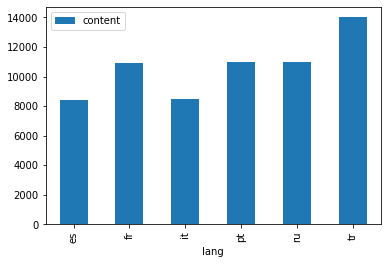

In [ ]:
wiki_toxic_comment_test[['lang', 'content']].groupby("lang").count().plot.bar()
plt.show()

Здесь дисбаланс по классам более выражен, однако надежду все же вселяет то, что большинство текстов на романских языках (испанский, французский, итальянский, португальский), они достаточно близки к английскому, плюс в английском как и в романских много заимствований из латыни, надеюсь, это как-то поможет.

valid

# Baseline Model

**Задание**

Бейзлайн модель, которая работает на отложенной выборке (train_test_split) и validation.csv (различие в точности может быть большим, но главное попробовать любыми способами его уменьшить и зафиксировать эксперименты) - 3 балла

Бейзлайн модель будем обучать на всех имеющихся данных

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
def baseline_model(clf_type, type_of_test, type_of_train, wiki_toxic_comment_train, wiki_toxic_comment_valid):
  if type_of_train == "balanced":
    k = len(wiki_toxic_comment_train[wiki_toxic_comment_train['toxic']==1])
    print("Train data is balanced")
    k_pos_example = wiki_toxic_comment_train[wiki_toxic_comment_train['toxic']==1].sample(k)
    k_neg_example = wiki_toxic_comment_train[wiki_toxic_comment_train['toxic']!=1].sample(k)
    subset = pd.concat([k_pos_example, k_neg_example])
    # subset = balanced_subsample(wiki_toxic_comment_train)
  else:
    print("Train data is NOT balanced")
    subset = wiki_toxic_comment_train.sample(n=100000)
  subset_X = subset.comment_text
  subset_y = subset.toxic
  if type_of_test == "train":
    print("Test is a part of train")
    vectorizer = TfidfVectorizer()
    comment_text_vect = vectorizer.fit_transform(subset_X) 
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(comment_text_vect, subset_y, test_size=0.33, random_state=8)
  else:
    print("Test is validation")
    vectorizer = TfidfVectorizer()
    X_sub_train =  vectorizer.fit_transform(subset_X) 
    y_sub_train = subset_y
    X_sub_test = vectorizer.transform(wiki_toxic_comment_valid.comment_text) 
    y_sub_test = wiki_toxic_comment_valid["toxic"]

  if clf_type == "LogReg":
    grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "solver":["lbfgs", "sag"]}
    logreg=LogisticRegression(max_iter=500)
    logreg_cv=GridSearchCV(logreg,grid,cv=10)
    logreg_cv.fit(X_sub_train, y_sub_train)
    model = LogisticRegression(**logreg_cv.best_params_, max_iter=500)
    print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
    print("accuracy :",logreg_cv.best_score_)
  else:
    model = clf_type
  
  cv_train_model(X_sub_train, y_sub_train.to_numpy(), X_sub_test, y_sub_test, folds=folds, plot_feature_importance=False, model=model)

  # acc = accuracy_score(predicted, y_sub_test)
  # micro_f1 = f1_score(predicted, y_sub_test, average = 'micro')
  # micro_p = precision_score(predicted, y_sub_test, average = 'micro')
  # micro_r = recall_score(predicted, y_sub_test, average = 'micro')
  # macro_f1 = f1_score(predicted, y_sub_test, average = 'macro')
  # macro_p = precision_score(predicted, y_sub_test, average = 'macro')
  # macro_r = recall_score(predicted, y_sub_test, average = 'macro')
  # print('acc={0:1.4f}'.format(acc))
  # print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
  # print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))
  # print('roc_auc_score ={0:1.4f}\n'.format(roc_auc_score(predicted, y_sub_test)))

In [11]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)



In [12]:
def cv_train_model(X, y, X_test, y_test, folds=folds, plot_feature_importance=False, model=None):
    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    
    valid_scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
          

        model.fit(X_train, y_train)      
        y_pred_test = model.predict_proba(X_test)[:, 1]
        y_pred_valid = model.predict_proba(X_valid)[:, 1]
        valid_score = roc_auc_score(y_valid, y_pred_valid)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        valid_scores.append(valid_score)
        prediction += y_pred_test  
        
    prediction /= (fold_n + 1)
    test_score = roc_auc_score(y_test, prediction)
    print('Cross Validation mean roc_auc_score: {0:.4f}, std: {1:.4f}.'.format(np.mean(valid_scores), np.std(valid_scores)))
    print("roc_auc_score on test data: {0:.4f}".format(test_score))
    

    return oof, prediction, valid_scores


In [ ]:
# clf_type = LogisticRegression(solver="lbfgs", max_iter=500)
# cls_types = ["LogReg", "SVD"]
clf_type = "LogReg"
baseline_model(clf_type, 'train', 'unbalanced', wiki_toxic_comment_train, wiki_toxic_comment_valid)
print("=======================Next type======================")
baseline_model(clf_type, 'val', 'unbalanced', wiki_toxic_comment_train, wiki_toxic_comment_valid)
print("=======================Next type======================")
baseline_model(clf_type, 'train', 'balanced', wiki_toxic_comment_train, wiki_toxic_comment_valid)
print("=======================Next type======================")
baseline_model(clf_type, 'val', 'balanced', wiki_toxic_comment_train, wiki_toxic_comment_valid)
print("=======================Next type======================")

Train data is NOT balanced
Test is a part of train


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


tuned hyperparameters :(best parameters)  {'C': 10, 'solver': 'lbfgs'}
accuracy : 0.9507611940298508
Cross Validation mean roc_auc_score: 0.9598, std: 0.0028.
roc_auc_score on test data: 0.9637
=======================Next type======================
Train data is NOT balanced
Test is validation


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


tuned hyperparameters :(best parameters)  {'C': 10, 'solver': 'sag'}
accuracy : 0.9512500000000002
Cross Validation mean roc_auc_score: 0.9630, std: 0.0021.
roc_auc_score on test data: 0.6452
=======================Next type======================
Train data is balanced
Test is a part of train


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


tuned hyperparameters :(best parameters)  {'C': 10, 'solver': 'lbfgs'}
accuracy : 0.8953723439884351
Cross Validation mean roc_auc_score: 0.9619, std: 0.0016.
roc_auc_score on test data: 0.9654
=======================Next type======================
Train data is balanced
Test is validation


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


tuned hyperparameters :(best parameters)  {'C': 10, 'solver': 'lbfgs'}
accuracy : 0.9009307075306319
Cross Validation mean roc_auc_score: 0.9657, std: 0.0029.
roc_auc_score on test data: 0.6606
=======================Next type======================


Хотела сразу сделать красивый пайплайн и оставила на ночь, не хватило иттераций, чтобы все сошлось, но резульаты гридсерча сохранились, придется пересчитать модели руками:

In [13]:
# clf_type = LogisticRegression('C': 10, 'solver': 'lbfgs', max_iter=500)
# cls_types = ["LogReg", "SVD"]

clf_type = LogisticRegression(C= 10, solver= 'lbfgs', max_iter=1000)
baseline_model(clf_type, 'train', 'unbalanced', wiki_toxic_comment_train, wiki_toxic_comment_valid)
print("=======================Next type======================")
clf_type = LogisticRegression(C=10, solver='sag', max_iter=1000)
baseline_model(clf_type, 'val', 'unbalanced', wiki_toxic_comment_train, wiki_toxic_comment_valid)
print("=======================Next type======================")
clf_type = LogisticRegression(C=10, solver='lbfgs', max_iter=1000)
baseline_model(clf_type, 'train', 'balanced', wiki_toxic_comment_train, wiki_toxic_comment_valid)
print("=======================Next type======================")
clf_type = LogisticRegression(C=10, solver ='lbfgs', max_iter=500)
baseline_model(clf_type, 'val', 'balanced', wiki_toxic_comment_train, wiki_toxic_comment_valid)
print("=======================Next type======================")

Train data is NOT balanced
Test is a part of train
Cross Validation mean roc_auc_score: 0.9616, std: 0.0030.
roc_auc_score on test data: 0.9628
=======================Next type======================
Train data is NOT balanced
Test is validation
Cross Validation mean roc_auc_score: 0.9615, std: 0.0026.
roc_auc_score on test data: 0.6632
=======================Next type======================
Train data is balanced
Test is a part of train
Cross Validation mean roc_auc_score: 0.9608, std: 0.0036.
roc_auc_score on test data: 0.9607
=======================Next type======================
Train data is balanced
Test is validation
Cross Validation mean roc_auc_score: 0.9652, std: 0.0014.
roc_auc_score on test data: 0.6455
=======================Next type======================


Предсказуемо на английском языке (когда тест - это часть выборки трейна) мы видим высокие результаты на вализации (хотя на сбалансированной выборке результаты хуже, с одной стороны оъясняется сильным уменьшением объема данных, общая выборка сократилась до 40000 текстов, в варианте, когда мы тестируем на часте трейна, на обучение устается только 70 процентов от этого числа, ну и также, все же этот алгоритм должен улавливать тенденцию, а мы сильно изменили распределение в выборке, поэтому на валидационном сете (где балансирвоки не было) результат ухудщился). При тесте на валидации результат неплохой, подозреваю, что это опять же связано с тем, что там 2/3 текстов на родственных языках (испанский/итальянский) вероятно, это сыграло свою роль, ну и кроме того, видимо есть какие-то сильные несемантические признаки, общие для этих языков (мы не делали преобработки, поэтому тут возможно сыграли роль и капс и знаки препинания и длин, мы видели в анализи данных, что статистически есть разница в распределнии длин для токсичных и нетоксичных текстов)

# Clear data
public kernal https://www.kaggle.com/shonenkov/tpu-inference-super-fast-xlmroberta

In [57]:
import nltk
nltk.download('punkt')

from nltk import sent_tokenize

LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

def get_sentences(text, lang='en'):
    return sent_tokenize(text, LANGS.get(lang, 'english'))

def exclude_duplicate_sentences(text, lang='en'):
    sentences = []
    for sentence in get_sentences(text, lang):
        sentence = sentence.strip()
        if sentence not in sentences:
            sentences.append(sentence)
    return ' '.join(sentences)

def clean_text(text, lang='en'):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = exclude_duplicate_sentences(text, lang)
    return text.strip()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [58]:
wiki_toxic_comment_train['clear_comments'] = wiki_toxic_comment_train.apply(lambda x: clean_text(x['comment_text']), axis=1)

In [59]:
wiki_toxic_comment_test['clear_comments'] = wiki_toxic_comment_test.apply(lambda x: clean_text(x['content'], x['lang']), axis=1)

In [60]:
wiki_toxic_comment_valid['clear_comments'] = wiki_toxic_comment_valid.apply(lambda x: clean_text(x['comment_text'], x['lang']), axis=1)

In [61]:
wiki_toxic_comment_valid.head()

,comment_text,lang,toxic,len_text,clear_comments
id,,,,,
0,Este usuario ni siquiera llega al rango de ...,es,0,252,Este usuario ni siquiera llega al rango de her...
1,Il testo di questa voce pare esser scopiazzato...,it,0,130,Il testo di questa voce pare esser scopiazzato...
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1,166,Vale. Sólo expongo mi pasado. Todo tiempo pasa...
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0,393,Bu maddenin alt başlığı olarak uluslararası il...
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0,426,Belçika nın şehirlerinin yanında ilçe ve belde...


In [ ]:
wiki_toxic_comment_train.shape

(223549, 9)

# Fix seed

In [ ]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Experiments

**Задание:**

Использование предобучнной модели из huggingface для обучения классификатора с оценкой на validation.csv - 3 балла

У нас мультилингвальные данные и первое, что приходит в голову - мультилингвальный берт, у нас не очень много данных, а колабе в берта много и не влезет, но это может повлиять на качество. Есть идея о том, что, возможно, тексты маркированные типом могут иметь какую-то дополнительную семантику, которой нет в тесте, попробуем сначала без них

### English bert with only toxic columns


#### random sample 

Уберем выбросы (длина больше 1000)

In [51]:
#only text with len <= 1000 chars, use text with toxic and non-toxic labels
filtred_data = wiki_toxic_comment_train[(wiki_toxic_comment_train["len_text"]<=1000) & 
                                        (wiki_toxic_comment_train["identity_hate"]!=1) & 
                                        (wiki_toxic_comment_train["severe_toxic"]!=1) &
                                        (wiki_toxic_comment_train["insult"]!=1) & 
                                        (wiki_toxic_comment_train["threat"]!=1) & 
                                        (wiki_toxic_comment_train["obscene"]!=1)]

In [53]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

**Задание:**

Использование токенизации на символьные нграммы (не параметром analyzer=’char’, а вручную или готовым энструментов вроде youtokentome - 2 балла

технически это не analyzer=’char’))) 

In [54]:
def prep_data(sentences, labels, MAX_LEN = 128, filter_by_len=True, bert_name='bert-base-cased'):
  filtred_by_len_number = 0
  tokenizer = BertTokenizer.from_pretrained(bert_name)
  input_ids = []
  labels_res = []
  for ind, sent in tqdm(enumerate(sentences)):
      encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
      if filter_by_len:
        if len(encoded_sent) <= MAX_LEN:
          input_ids.append(encoded_sent)
          labels_res.append(labels[ind])
          filtred_by_len_number+=1
      else:
        input_ids.append(encoded_sent)
        labels_res.append(labels[ind])
        filtred_by_len_number+=1

  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
  attention_masks = []
  for sent in input_ids:
      att_mask = [int(token_id > 0) for token_id in sent]
      attention_masks.append(att_mask)
  assert len(input_ids)==len(labels_res), "different number of samples and labels"
  print("Unput sentences number: {}".format(len(sentences)))
  print("Filtered(output) sentence number: {}".format(filtred_by_len_number))
  return input_ids, attention_masks, labels_res

In [55]:
from sklearn.metrics import roc_auc_score
def train_bert(train, 
               test, 
               text_col_name="comment_text", 
               label="toxic",
               device="cuda",
               batch_size=16,
               epochs=7,
               bert_name='bert-base-cased'
               ):

  train_input_ids, train_attention_masks, labels_train = prep_data(train[text_col_name].values.tolist(),
                                                                   train[label].values.tolist(),
                                                                   filter_by_len=True,
                                                                   bert_name=bert_name)
  test_input_ids, test_attention_masks, labels_test = prep_data(test[text_col_name].values.tolist(),
                                                                test[label].values.tolist(),
                                                                filter_by_len=False,
                                                                bert_name=bert_name)

  train_inputs = torch.tensor(train_input_ids)
  validation_inputs = torch.tensor(test_input_ids)

  train_labels = torch.tensor(labels_train)
  validation_labels = torch.tensor(labels_test)

  train_masks = torch.tensor(train_attention_masks)
  validation_masks = torch.tensor(test_attention_masks)
  
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  model = BertForSequenceClassification.from_pretrained(bert_name, 
                                                        num_labels = len(train[label].unique()), 
                                                        output_attentions = False, 
                                                        output_hidden_states = True)
  model = model.to(device)
  optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 )
  
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 100, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  
  loss_values = []

  for epoch_i in range(0, epochs):
      embeddings = []

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')
      t0 = time.time()
      total_loss = 0
      model.train()

      for step, batch in enumerate(train_dataloader):
          if step % 40 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          model.zero_grad()        

          outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask, 
                      labels=b_labels)
          
          loss  = outputs[0]
          embeddings.append(outputs[2][-1][:,0,:])
          total_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
          scheduler.step()

      avg_train_loss = total_loss / len(train_dataloader)            
      loss_values.append(avg_train_loss)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
          
      print("")
      print("Running Validation...")

      t0 = time.time()
      test_targets, test_pred_class = [], []

      model.eval()

      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0

      for batch in validation_dataloader:
          
          batch = tuple(t.to(device) for t in batch)
          
          b_input_ids, b_input_mask, b_labels = batch
          with torch.no_grad():        
              outputs = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)
          logits = outputs[0]

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.cpu().numpy()
          test_targets.append(label_ids)
          test_pred_class.append(np.argmax(logits, axis=1))
          
          # Calculate the accuracy for this batch of test sentences.          
          # Accumulate the total accuracy.

          nb_eval_steps += 1
      test_targets = np.concatenate(test_targets).squeeze()
      test_pred_class = np.concatenate(test_pred_class).squeeze()

      f1 = f1_score(test_targets, test_pred_class, average='micro')
      print(classification_report(test_targets, test_pred_class))

      # Report the final accuracy for this validation run.
      print("  F1: {0:.4f}".format(f1))
      print("  ROC AUC: {0:.4f}".format(roc_auc_score(test_targets, test_pred_class)))
      print("  Validation took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Training complete!")
  return model

In [ ]:
m = train_bert(filtred_data[:10000],
               wiki_toxic_comment_valid,
               text_col_name="clear_comments", 
               label="toxic",
               bert_name="bert-base-multilingual-cased" 
               )

0it [00:00, ?it/s]

10000it [00:06, 1493.68it/s]


Unput sentences number: 10000
Filtered(output) sentence number: 8722


2584it [00:02, 981.31it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (936 > 512). Running this sequence through the model will result in indexing errors
2782it [00:02, 968.96it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
3302it [00:03, 979.97it/s] Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors
6683it [00:06, 913.29it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
6871it [00:06, 891.46it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through 

Unput sentences number: 8000
Filtered(output) sentence number: 8000




======== Epoch 1 / 7 ========
Training...
  Batch    40  of    546.    Elapsed: 0:00:15.
  Batch    80  of    546.    Elapsed: 0:00:30.
  Batch   120  of    546.    Elapsed: 0:00:46.
  Batch   160  of    546.    Elapsed: 0:01:02.
  Batch   200  of    546.    Elapsed: 0:01:18.
  Batch   240  of    546.    Elapsed: 0:01:35.
  Batch   280  of    546.    Elapsed: 0:01:51.
  Batch   320  of    546.    Elapsed: 0:02:08.
  Batch   360  of    546.    Elapsed: 0:02:24.
  Batch   400  of    546.    Elapsed: 0:02:40.
  Batch   440  of    546.    Elapsed: 0:02:57.
  Batch   480  of    546.    Elapsed: 0:03:13.
  Batch   520  of    546.    Elapsed: 0:03:30.

  Average training loss: 0.17
  Training epcoh took: 0:03:40

Running Validation...
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      6770
           1       1.00      0.00      0.00      1230

    accuracy                           0.85      8000
   macro avg       0.92      0.50      0.4

KeyboardInterrupt: ignored

Лосс уже почти не падал, а у меня заканчиволось время, поэтому я его остановила

Лучшее, чего удалось добиться: **ROC AUC: 0.5946**

#### balanced random sampling

Добавим преобработку

In [44]:
k = 5000
k_pos_example = filtred_data[filtred_data['toxic']==1].sample(k)
k_neg_example = filtred_data[filtred_data['toxic']!=1].sample(k)
sub_sampled_data = pd.concat([k_pos_example, k_neg_example])

In [34]:
m = train_bert(sub_sampled_data,
               wiki_toxic_comment_valid,
               text_col_name="clear_comments", 
               label="toxic",
               bert_name="bert-base-multilingual-cased" 
               )

10000it [00:07, 1274.75it/s]


Unput sentences number: 10000
Filtered(output) sentence number: 8854


2593it [00:03, 726.22it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (936 > 512). Running this sequence through the model will result in indexing errors
2835it [00:03, 775.20it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
3313it [00:04, 750.30it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors
6678it [00:08, 725.14it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
6827it [00:08, 707.35it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through t

Unput sentences number: 8000
Filtered(output) sentence number: 8000




======== Epoch 1 / 7 ========
Training...
  Batch    40  of    554.    Elapsed: 0:00:15.
  Batch    80  of    554.    Elapsed: 0:00:31.
  Batch   120  of    554.    Elapsed: 0:00:46.
  Batch   160  of    554.    Elapsed: 0:01:02.
  Batch   200  of    554.    Elapsed: 0:01:18.
  Batch   240  of    554.    Elapsed: 0:01:34.
  Batch   280  of    554.    Elapsed: 0:01:51.
  Batch   320  of    554.    Elapsed: 0:02:08.
  Batch   360  of    554.    Elapsed: 0:02:25.
  Batch   400  of    554.    Elapsed: 0:02:41.
  Batch   440  of    554.    Elapsed: 0:02:57.
  Batch   480  of    554.    Elapsed: 0:03:14.
  Batch   520  of    554.    Elapsed: 0:03:30.

  Average training loss: 0.40
  Training epcoh took: 0:03:44

Running Validation...
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      6770
           1       0.52      0.42      0.46      1230

    accuracy                           0.85      8000
   macro avg       0.71      0.67      0.6

Лучший результат: 

F1: 0.7404
  
ROC AUC: 0.7618

Обучимся на максимуме данных, которые у нас есть (токсичные без типа токсичности)

In [47]:
k = len(filtred_data[filtred_data['toxic']==1])
k_pos_example = filtred_data[filtred_data['toxic']==1].sample(k)
k_neg_example = filtred_data[filtred_data['toxic']!=1].sample(k)
sub_sampled_data = pd.concat([k_pos_example, k_neg_example])

In [48]:
m = train_bert(sub_sampled_data,
               wiki_toxic_comment_valid,
               text_col_name="clear_comments", 
               label="toxic",
               bert_name="bert-base-multilingual-cased" 
               )

13922it [00:09, 1421.96it/s]


Unput sentences number: 13922
Filtered(output) sentence number: 12341


2577it [00:03, 853.52it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (936 > 512). Running this sequence through the model will result in indexing errors
2847it [00:03, 874.79it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
3293it [00:03, 837.48it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors
6699it [00:07, 786.78it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
6871it [00:08, 791.60it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through t

Unput sentences number: 8000
Filtered(output) sentence number: 8000

======== Epoch 1 / 7 ========
Training...
  Batch    40  of    772.    Elapsed: 0:00:15.
  Batch    80  of    772.    Elapsed: 0:00:30.
  Batch   120  of    772.    Elapsed: 0:00:46.
  Batch   160  of    772.    Elapsed: 0:01:02.
  Batch   200  of    772.    Elapsed: 0:01:17.
  Batch   240  of    772.    Elapsed: 0:01:33.
  Batch   280  of    772.    Elapsed: 0:01:49.
  Batch   320  of    772.    Elapsed: 0:02:05.
  Batch   360  of    772.    Elapsed: 0:02:22.
  Batch   400  of    772.    Elapsed: 0:02:38.
  Batch   440  of    772.    Elapsed: 0:02:54.
  Batch   480  of    772.    Elapsed: 0:03:11.
  Batch   520  of    772.    Elapsed: 0:03:27.
  Batch   560  of    772.    Elapsed: 0:03:44.
  Batch   600  of    772.    Elapsed: 0:04:00.
  Batch   640  of    772.    Elapsed: 0:04:17.
  Batch   680  of    772.    Elapsed: 0:04:33.
  Batch   720  of    772.    Elapsed: 0:04:50.
  Batch   760  of    772.    Elapsed: 0:05:

Лучший результат:

ROC AUC: 0.7449